In [1]:
import itertools
import cPickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from sklearn.feature_selection import chi2,f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_curve,precision_score,recall_score,auc,precision_recall_curve
from sklearn.cross_validation import train_test_split
import xgboost as xgb

In [2]:
seed = 9999
plt.style.use('ggplot')
%matplotlib inline

## Index
* [Load emails from CSV](#Load-emails-information-from-CSV-file)
* [Answer Question 1](#Answer-question-1)
* [Explore the data](#Explore-the-data)
    * [Chi-square test and F-test](#Chi-square-test-and-F-test)
    * [previous purchase history vs. response](#previous-purchase-vs.-response)
    * [user's country vs. response](#user's-country-vs.-response)
    * [email's version vs. response](#email's-version-vs.-response)
    * [weekday vs. reponse](#weekday-vs.-response)
    * [email text vs. response](#email-text-vs.-response)
    * [sending hour vs. response](#sending-hour-vs.-response)
* [Answer Question 4](#Answer-question-4)
* [Build Predictive Model](#Build-Predictive-Model)
    * [Prepare the data](#Prepare-the-data)
    * [Train the model](#Train-the-model)
    * [Plot ROC curve and choose better probability threshold](#Plot-ROC-curve-and-choose-better-probability-threshold)
* [Answer question 2 and question 3's first part](#Answer-question-2-and-question-3's-first-part)
* [Answer question 3's second part](#Answer-question-3's-second-part)
* Answers summary:
    * [Answer Question 1](#Answer-question-1)
    * [Answer question 2 and question 3's first part](#Answer-question-2-and-question-3's-first-part)
    * [Answer question 3's second part](#Answer-question-3's-second-part)
    * [Answer Question 4](#Answer-question-4)

## Load emails information from CSV file

In [3]:
emails = pd.read_csv("email_table.csv",index_col="email_id")

Columns:
* email_id : the Id of the email that was sent. It is unique by email 
* email_text : there are two versions of the email: one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs) 
* email_version : some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,"). 
* hour : the user local time when the email was sent. 
* weekday : the day when the email was sent. 
* user_country : the country where the user receiving the email was based. It comes from the user ip address when she created the account. 
* user_past_purchases : how many items in the past were bought by the user receiving the email

In [4]:
emails.sample(10)# view some data to get a feeling

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
208412,long_email,personalized,13,Saturday,US,7
853919,short_email,personalized,11,Sunday,FR,4
657911,long_email,personalized,4,Friday,US,1
997300,short_email,personalized,8,Tuesday,US,9
518617,long_email,personalized,5,Wednesday,FR,6
92422,long_email,personalized,5,Friday,US,1
540502,short_email,personalized,6,Thursday,FR,1
166737,short_email,generic,6,Sunday,US,4
609384,short_email,personalized,10,Monday,US,6


In [5]:
# email_text : there are two versions of the email: 
# one has "long text" (i.e. has 4 paragraphs) and one has "short text" (just 2 paragraphs)
# since we need to change all features into numbers, so I replace 'email_text' with 'paragraphs'
emails["paragraphs"] = np.where(emails.email_text == 'short_email',2,4)
del emails["email_text"]

# email_version : some emails were "personalized" (i.e. they had name of the user in incipit, such as "Hi John,"), 
# while some emails were "generic" (the incipit was just "Hi,").
emails["is_personal"] = (emails.email_version == "personalized").astype(np.int)
del emails["email_version"]

weekday2index = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":7}
emails["weekday"] = emails.weekday.map(weekday2index)

# rename long column names to shorter names, make it easier to read
emails.rename(columns={'user_past_purchases':'purchases','user_country':'country'},inplace=True)

assemble emails' response together

In [6]:
emails["response"] = "received"

open_users = pd.read_csv("email_opened_table.csv").email_id
emails.loc[open_users,"response"] = "opened"

click_users = pd.read_csv("link_clicked_table.csv").email_id
emails.loc[click_users,"response"] = 'clicked'

In [7]:
emails.head()# check some data to get a feeling

,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,
85120,2,7,US,5,2,1,received
966622,12,7,UK,2,4,1,clicked
777221,11,3,US,2,4,1,received
493711,6,1,UK,1,2,0,received
106887,14,1,US,6,4,0,received


In [8]:
emails.to_csv("clean_emails.csv",index_label="email_id")

## Answer question 1
* <span style='color:blue;font-weight:bold'>What percentage of users opened the email?</span>
* <span style='color:blue;font-weight:bold'>what percentage clicked on the link within the email?</span>

In [9]:
rslt_dist = emails.response.value_counts(normalize=True)
rslt_dist

received    0.89605
opened      0.08276
clicked     0.02119
Name: response, dtype: float64

In [10]:
print "{:.2f}% of users opened the email".format((1 - rslt_dist.received) * 100)
print "{:.2f}% of users clicked the link".format(rslt_dist.clicked * 100)

10.39% of users opened the email
2.12% of users clicked the link


## Explore the data

In [11]:
def count_result_ratio(df):
    counts = df.response.value_counts(normalize=True)
    counts['total'] = df.shape[0]
    return counts

def grp_count_plotbar(key):
    grpresult = emails.groupby(key).apply(count_result_ratio)
    # grpresult.loc[:,["received","opened",'clicked']].plot(kind='bar')
    grpresult.loc[:,['clicked']].plot(kind='bar',title='click ratio vs. {}'.format(key))
    plt.ylabel('click ratio')
    return grpresult

### Chi-square test and F-test

In [12]:
resp_lb_encoder = LabelEncoder()
cnty_lb_encoder = LabelEncoder()

X = emails.copy()
y = resp_lb_encoder.fit_transform(X.response)
del X["response"]

feat_names = ["hour","weekday","country","purchases","paragraphs","is_personal" ]
X = X.loc[:,feat_names]
X["country"] = cnty_lb_encoder.fit_transform(X.country)

chi2scores,_ = chi2(X,y)
fscores,_ = f_classif(X,y)

feat_scores = pd.DataFrame({"chi2scores":chi2scores,"fscores":fscores},index=feat_names)

In [13]:
feat_scores.sort_values(by='chi2scores',ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
hour,147.815921,33.992047
paragraphs,53.952439,81.209295


In [14]:
feat_scores.sort_values(by="fscores",ascending=False)

,chi2scores,fscores
purchases,3448.795660,663.388596
country,378.554465,435.696911
is_personal,316.752872,317.427444
weekday,210.006087,105.002643
paragraphs,53.952439,81.209295
hour,147.815921,33.992047


from the test result, we can know that,
* important features: ** previous purchase counts, user's country, email's version (personal or general) **
* not so important features **maybe** include: ** weekday, email's text (short or long), hour to send the email **

### previous purchase vs. response

In [15]:
rslt_grpby_purchase = emails.groupby("purchases").apply(count_result_ratio).unstack()
rslt_grpby_purchase.fillna(value=0,inplace=True)

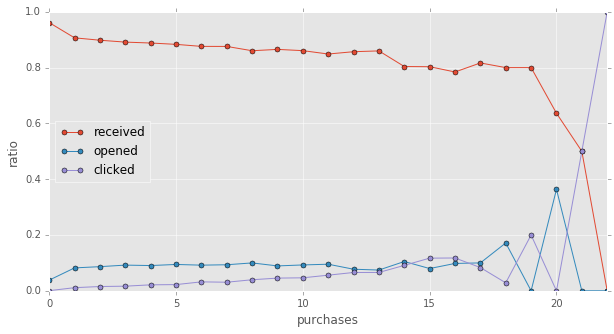

In [16]:
plt.rc('figure', figsize=(10, 5))
rslt_grpby_purchase.loc[:,["received","opened",'clicked']].plot(marker='o',markersize=5)
plt.ylabel("ratio")

from above plot, we can know, <span style='color:orange;font-weight:bold;font-size:1.5em'>the more items a certain user purchased previously, the more likely that user will open the email or click the link.</span>

### user's country vs. response

response,received,opened,clicked,total
country,,,,
ES,0.960570,0.031103,0.008327,9967.0
FR,0.958779,0.033217,0.008004,9995.0
UK,0.879282,0.096043,0.024675,19939.0
US,0.880481,0.095160,0.024360,60099.0


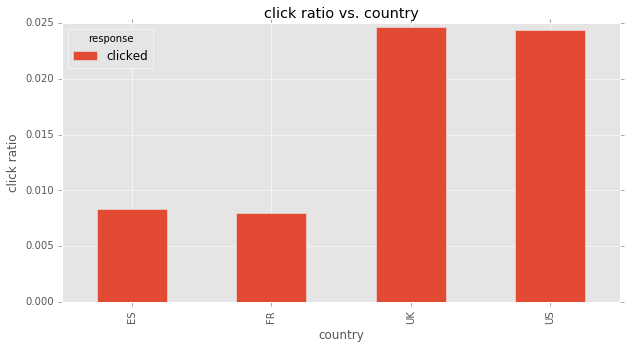

In [17]:
grp_count_plotbar('country')

from above plots, we see that, 'open percentage' and 'click percentage' is much higher (nearly 3 times) in UK and US than in France and Spain. 

this may be the <span style='color:orange;font-weight:bold;font-size:1.5em'>translation issue. I guess the emails are written in English, which is unreadable to some non-English-speaking users, which cause the low 'click ratio' in non-English-speaking countries.</span>

### email's version vs. response

response,received,opened,clicked,total
is_personal,,,,
0,0.920034,0.064829,0.015137,50209.0
1,0.871864,0.100842,0.027294,49791.0


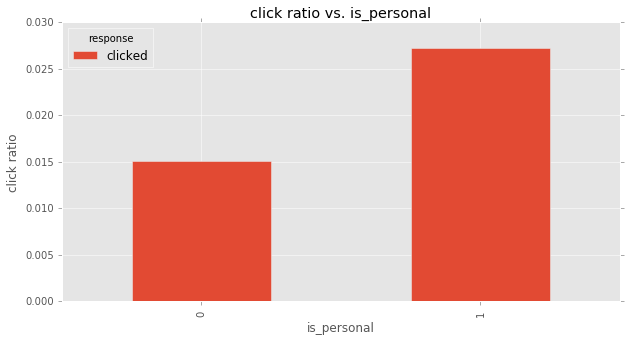

In [18]:
grp_count_plotbar('is_personal')

<span style='color:orange;font-weight:bold;font-size:1.5em'>'personalized email' has higher 'click ratio' than 'general email'</span>. this is very easy to understand. Having my name in the recipient, at least I am some kind of 'important' to the company, other than some ordinary people which the company don't bother to remember his name.

### weekday vs. response

response,received,opened,clicked,total
weekday,,,,
1,0.883590,0.093504,0.022906,14363.0
2,0.879092,0.096019,0.024889,14143.0
3,0.879296,0.093084,0.027620,14084.0
4,0.881348,0.094207,0.024445,14277.0
5,0.925019,0.060944,0.014037,14177.0
6,0.912005,0.070149,0.017846,14569.0
7,0.911448,0.071801,0.016751,14387.0


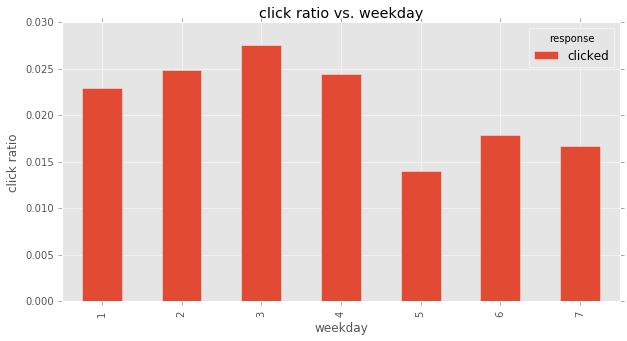

In [19]:
grp_count_plotbar('weekday')

<span style='color:orange;font-weight:bold;font-size:1.5em'>Friday, Saturday, Sunday have obviously lower 'click ratio' than Monday to Thursday</span>. People normally don't process emails during weekends.

### email text vs. response

response,received,opened,clicked,total
paragraphs,,,,
2,0.883698,0.092430,0.023872,49724.0
4,0.908266,0.073196,0.018538,50276.0


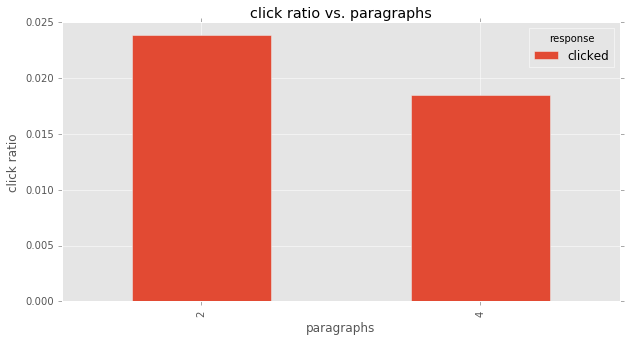

In [20]:
grp_count_plotbar('paragraphs')

### sending hour vs. response

response,received,opened,clicked,total
hour,,,,
1,0.910840,0.071032,0.018128,2703.0
2,0.911589,0.072089,0.016322,3676.0
3,0.915184,0.065293,0.019523,4610.0
4,0.911419,0.072394,0.016186,5622.0
5,0.917417,0.064570,0.018013,6551.0
6,0.909176,0.073677,0.017147,7465.0
7,0.909434,0.072282,0.018284,8204.0
8,0.911407,0.069659,0.018933,8398.0
9,0.873725,0.100481,0.025794,8529.0


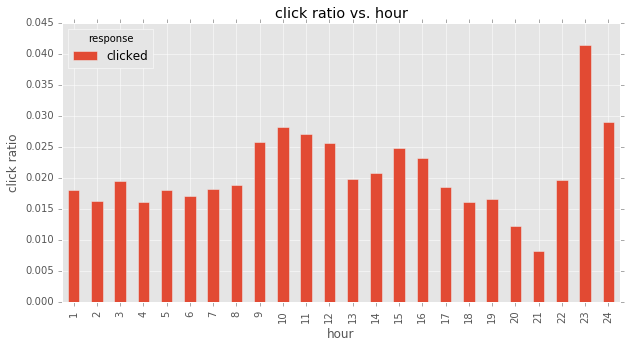

In [21]:
grp_count_plotbar('hour')

although from above plot, it seems 'sending hour' has some impact on 'clicked ratio'. however, that may be caused by much fewer examples in late hours. also according to [statistical test](#Chi-square-test-and-F-test)'s result, I don't think 'sending hour' is an important feature, and won't include it in my model.

## Answer question 4
<span style='color:blue;font-weight:bold'>Did you ﬁnd any interesting pattern on how the email campaign performed for diﬀerent segments of users? Explain.</span>

from above explorary analysis, I can find some interesting patterns listed below:
* [The more item a certain user purchased in the past, the more likely that user will click the link](#previous-purchase-vs.-response)
* [Users from English-speaking coutries are more likely to click the link](#user's-country-vs.-response), which may be caused by some translation issue.
* [Personalized email is more likely to be opened and clicked](#email's-version-vs.-response)
* [Emails sent at weekends is less likely to be opened and clicked](#weekday-vs.-response)
* [Sending hour and #Paragraphs are not very important features to affect click rate](#Chi-square-test-and-F-test)

## Build Predictive Model

In this section, I will build a model to predict whether a user will open the email and click the link inside it.

### Prepare the data

In [22]:
del X
X = emails.copy()
X.sample(5)# get a feeling about current data

,hour,weekday,country,purchases,paragraphs,is_personal,response
email_id,,,,,,,
785135,10,4,UK,4,4,0,received
479664,4,5,UK,0,4,0,received
233005,19,5,US,10,4,0,received
285041,15,2,US,7,4,1,received
10411,2,5,UK,5,4,0,received


In [23]:
# select original features
# 'paragraphs' isn't an important feature, but I will include it, and see how RF say about it
X = X.loc[:,["country","purchases","paragraphs","is_personal"] ]

# create new feature
X['is_weekend'] = (emails.weekday>=5).astype(int)

# One-Hot-Encode 'country' feature
X = pd.get_dummies(X,columns=["country"],drop_first=True)

# prepare the target
y = (emails.response == 'clicked').astype(int)

In [24]:
X.sample(5)# check the data

,purchases,paragraphs,is_personal,is_weekend,country_FR,country_UK,country_US
email_id,,,,,,,
231912,5,2,1,1,0.0,0.0,0.0
538951,5,2,1,0,0.0,0.0,0.0
716309,5,2,1,0,1.0,0.0,0.0
695780,6,4,1,1,0.0,0.0,1.0
586318,2,4,1,0,0.0,0.0,1.0


In [25]:
# split for training and testing
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,test_size=0.33333,random_state = seed)

In [26]:
print 'Train set shape: {}, positive ratio={:.3f}'.format(Xtrain.shape,ytrain.mean())
print 'Test set shape: {}, positive ratio={:.3f}'.format(Xtest.shape,ytest.mean())

Train set shape: (66667, 7), positive ratio=0.021
Test set shape: (33333, 7), positive ratio=0.022


### Train the model

Due to time limitation, I will just train one GBM model.

<span style='color:red;font-weight:bold;font-size:1.5em'>If given sufficient time, I will apply fowllowing strategies to improve the model:</span>
* <span style='color:red'>build multiple models, and ensemble them (average or stacking) to improve the prediction performance.</span>
* <span style='color:red'>try more hyper-parameters to find better ones.</span>

In [27]:
train_matrix = xgb.DMatrix(Xtrain,ytrain)
test_matrix = xgb.DMatrix(Xtest)

In [28]:
params = {}
params['objective'] = 'binary:logistic'  # output probabilities
params['eval_metric'] = 'auc'
params["num_rounds"] = 300
params["early_stopping_rounds"] = 30
# params['min_child_weight'] = 2
params['max_depth'] = 6
params['eta'] = 0.1
params["subsample"] = 0.8
params["colsample_bytree"] = 0.8

cv_results = xgb.cv(params,train_matrix,
                    num_boost_round = params["num_rounds"],
                    nfold = params.get('nfold',5),
                    metrics = params['eval_metric'],
                    early_stopping_rounds = params["early_stopping_rounds"],
                    verbose_eval = True,
                    seed = seed)

[0]	train-auc:0.677493+0.00828721	test-auc:0.672627+0.00998874
[1]	train-auc:0.697782+0.00882727	test-auc:0.696658+0.0206434
[2]	train-auc:0.70463+0.00828662	test-auc:0.702561+0.0208773
[3]	train-auc:0.711914+0.00409068	test-auc:0.710696+0.0228788
[4]	train-auc:0.714488+0.00278646	test-auc:0.712043+0.0193185
[5]	train-auc:0.717649+0.00424529	test-auc:0.714465+0.0207032
[6]	train-auc:0.719344+0.00510737	test-auc:0.715544+0.0193956
[7]	train-auc:0.724209+0.00365824	test-auc:0.719632+0.0165027
[8]	train-auc:0.729045+0.00371847	test-auc:0.72386+0.0148701
[9]	train-auc:0.730501+0.00375046	test-auc:0.724429+0.0142755
[10]	train-auc:0.732467+0.0026696	test-auc:0.726337+0.0156743
[11]	train-auc:0.735537+0.00246068	test-auc:0.729132+0.0162888
[12]	train-auc:0.737188+0.00155158	test-auc:0.730848+0.0168706
[13]	train-auc:0.738333+0.00183292	test-auc:0.73156+0.016002
[14]	train-auc:0.740307+0.00175305	test-auc:0.732328+0.0157333
[15]	train-auc:0.741514+0.00256378	test-auc:0.733169+0.0154183
[16]	t

In [29]:
n_best_trees = cv_results.shape[0]
print "best number of trees: {}".format(n_best_trees)

best number of trees: 53


In [30]:
watchlist = [(train_matrix, 'train')]
gbt = xgb.train(params, train_matrix, n_best_trees,watchlist)

[0]	train-auc:0.702188
[1]	train-auc:0.704781
[2]	train-auc:0.71018
[3]	train-auc:0.714805
[4]	train-auc:0.715547
[5]	train-auc:0.726005
[6]	train-auc:0.725821
[7]	train-auc:0.725022
[8]	train-auc:0.7335
[9]	train-auc:0.735223
[10]	train-auc:0.736723
[11]	train-auc:0.74205
[12]	train-auc:0.742289
[13]	train-auc:0.742862
[14]	train-auc:0.743885
[15]	train-auc:0.743699
[16]	train-auc:0.742109
[17]	train-auc:0.744295
[18]	train-auc:0.746087
[19]	train-auc:0.74534
[20]	train-auc:0.743896
[21]	train-auc:0.74842
[22]	train-auc:0.7502
[23]	train-auc:0.750863
[24]	train-auc:0.750096
[25]	train-auc:0.752116
[26]	train-auc:0.752202
[27]	train-auc:0.752974
[28]	train-auc:0.752529
[29]	train-auc:0.752424
[30]	train-auc:0.753932
[31]	train-auc:0.753449
[32]	train-auc:0.754669
[33]	train-auc:0.755053
[34]	train-auc:0.755589
[35]	train-auc:0.755971
[36]	train-auc:0.757188
[37]	train-auc:0.757529
[38]	train-auc:0.757631
[39]	train-auc:0.757584
[40]	train-auc:0.757568
[41]	train-auc:0.758382
[42]	train

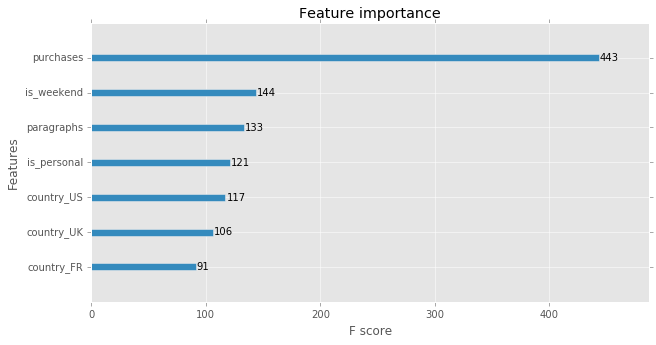

In [31]:
# plot feature importances
xgb.plot_importance(gbt)

above feature importance match the result from [explorary analysis](#Explore-the-data).

### Plot ROC curve and choose better probability threshold

<span style='color:orange;font-size:1.5em'>since the data is highly imbalanced (positive examples is only 2% of the total examples), if using default probability threshold (0.5), the model just classify every example as negative, so we need to plot the ROC curve and choose a better probability threshold.</span>

<span style='color:red;font-weight:bold'>But ROC cannot be plot on either training set or test set. </span>so I split the original train set into 'training' and 'validation' sets, <span style='color:orange;font-weight:bold'>re-train on 'training set' and plot ROC on 'validation set'. </span>

In [32]:
print "n_best_trees={},xgboost parameters: ".format(n_best_trees)
params

n_best_trees=53,xgboost parameters: 


{'colsample_bytree': 0.8,
 'early_stopping_rounds': 30,
 'eta': 0.1,
 'eval_metric': 'auc',
 'max_depth': 6,
 'num_rounds': 300,
 'objective': 'binary:logistic',
 'subsample': 0.8}

In [33]:
# define a function, avoid pollute the current namespace
def validation_roc():
    Xtrain_only,Xvalid,ytrain_only,yvalid = train_test_split(Xtrain,ytrain,test_size=0.2,random_state=seed)
    
    train_only_matrix = xgb.DMatrix(Xtrain_only,ytrain_only)
    valid_matrix = xgb.DMatrix(Xvalid)
    
    # retrain on training set
    gbt_train_only = xgb.train(params, train_only_matrix, n_best_trees)
    
    # predict on validation set
    yvalid_probas = gbt_train_only.predict(valid_matrix, ntree_limit=n_best_trees)
    
    d = {}
    d['FPR'],d['TPR'],d['Threshold'] = roc_curve(yvalid,yvalid_probas)
    return pd.DataFrame(d)

In [34]:
roc_results = validation_roc()

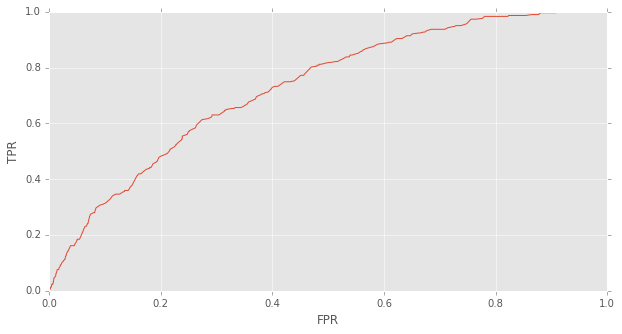

In [35]:
_ = plt.figure()
plt.plot(roc_results.FPR,roc_results.TPR)
plt.xlabel("FPR")
plt.ylabel('TPR')

according to above ROC curve and make a compromise between Precision and Recall, <span style='color:orange;font-weight:bold;font-size:1.5em'>I decide to choose a threshold which makes TPR at about 0.6, then FPR will be about 0.3, which I think is acceptable.</span>

In [36]:
roc_results.loc[(roc_results.TPR > 0.6) & (roc_results.TPR < 0.65),:]

,FPR,TPR,Threshold
192,0.274192,0.613861,0.030303
193,0.274729,0.613861,0.030261
194,0.274960,0.613861,0.030247
195,0.284245,0.617162,0.030224
196,0.288389,0.620462,0.029755
197,0.288619,0.620462,0.029587
198,0.290998,0.623762,0.029482
199,0.291229,0.623762,0.029463
200,0.291996,0.630363,0.029195
201,0.292380,0.630363,0.029118


In [37]:
# choose a threshold based on ROC
# FPR=0.292380, TPR=0.630363, Threshold=0.029118
pos_prob_threshold = 0.029118

def adjust_predict(matrix):
    y_probas = gbt.predict(matrix, ntree_limit=n_best_trees)
    return (y_probas > pos_prob_threshold).astype(int)

In [38]:
ytrain_pred = adjust_predict(train_matrix)
print classification_report(ytrain,ytrain_pred)

             precision    recall  f1-score   support

          0       0.99      0.72      0.83     65265
          1       0.05      0.65      0.09      1402

avg / total       0.97      0.71      0.82     66667



In [39]:
ytest_pred = adjust_predict(test_matrix)
print classification_report(ytest,ytest_pred)

             precision    recall  f1-score   support

          0       0.99      0.71      0.83     32616
          1       0.04      0.60      0.08       717

avg / total       0.97      0.71      0.81     33333



<a id='test-precision-recall'></a>
<span style='color:orange;font-weight:bold;font-size:1.5em'>more accurate Precision and Recall</span>

In [40]:
print "test precision: {:.2f}%".format(precision_score(ytest,ytest_pred) * 100)
print "test recall: {:.2f}%".format(recall_score(ytest,ytest_pred) * 100)

test precision: 4.35%
test recall: 60.11%


In [41]:
gbt.save_model('gbt.model')

## Answer question 2 and question 3's first part
* <span style='color:blue;font-weight:bold'>The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?</span>
* <span style='color:blue;font-weight:bold'>By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?</span>

I have build a Gradient Boosting Tree model in previous section which predicts whether a user will click the link or not. Then the new email campaign strategy will be: <span style='color:orange;font-weight:bold;font-size:1.5em'>only send email to users which my GBM model predicts positive.</span>

In [48]:
n_emails_old_sent = ytest_pred.shape[0]
n_emails_new_sent = ytest_pred.sum()
saving_percentage = 100 - n_emails_new_sent * 100.0/n_emails_old_sent
pd.Series({'#emails sent in old way': n_emails_old_sent,
           '#emails sent in new way': n_emails_new_sent,
           'saving percentage (%)': saving_percentage})

#emails sent in new way     9904.000000
#emails sent in old way    33333.000000
saving percentage (%)         70.287703
dtype: float64

according to its [predictive result on test set](#test-precision-recall) 
* <span style='color:orange;'>my model only need to send 30% of the old email amount, saving 70% amount.</span>
* <span style='color:orange;'>my model will cover 60% of valued users which will click the link. </span>
* <span style='color:orange;'>4.35% of the receiver will open email and click the link. </span> compare with [old strategy](#Answer-question-1), whose click rate is ** 2.12% **, <span style='color:red;'>my new strategy can double the click rate</span>.

## Answer question 3's second part
<span style='color:blue;font-weight:bold'>By how much do you think your model would improve click through rate ( deﬁned as # of users who click on the link / total users who received the email). How would you test that?</span>

To test my conclusion, we need to perform a A/B test:
1. randomly assign users to two groups, Control group and Experiment group.
2. in Control group, still use the old email-campaign strategy, i.e., just send emails to all users in Control group.
3. in Experiment group, use my model to predict whether the user will click the link or not. and only send emails to those users whose predictive result is positive.
4. then we preform a one-tail unpaired t-test to test whether Experiement group's population proportion is higher than Control group's population proportion.